# Import

In [2]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
from random import randint
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# Extract train data

In [3]:
# An empty list. We will insert the data into this list in (img_path, label) format
features = []
targets = []

# Get the list of all the images
images = glob.glob("data/train/all/*")
random.shuffle(images)

image_size = 155

# Add the datas on lists. target : 0 for normal case, 1 for pneumonia case
for img in images:
    curImg = (Image.open(img).resize((image_size, image_size)))
    curImg = np.array(np.expand_dims(curImg, axis=-1))
    features.append(curImg)
    if "virus" in img:
        target = [1, 0]
    elif "bacteria" in img:
        target = [1, 0]
    else:
        target = [0, 1]
    targets.append(target)

features = np.array(features)
targets = np.array(targets)

print("Shape train_data", features.shape)
print("Shape targets", targets.shape)



Shape train_data (2398, 155, 155, 1)
Shape targets (2398, 2)


# View images

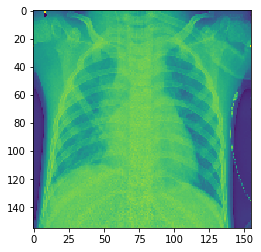

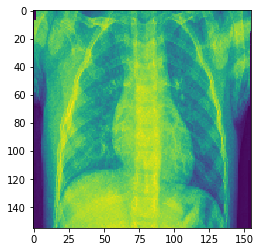

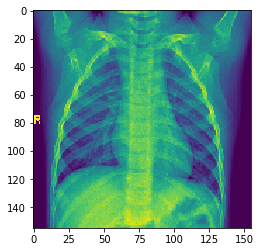

In [7]:
for a in [randint(0, len(targets)) for _ in range(3)]:
    plt.imshow(np.squeeze(features[a]))
    plt.show()

# Create train data

In [8]:
# Take 10% of the train dataset for the validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(features, targets, test_size=0.1, random_state=42)

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)

X_train.shape (2158, 155, 155, 1)
X_valid.shape (240, 155, 155, 1)
y_train.shape (2158, 2)
y_valid.shape (240, 2)


# Create model

In [9]:
# Placeholder
x = tf.placeholder(tf.float32, (None, image_size, image_size, 1), name="Image")
y = tf.placeholder(tf.float32, (None, 2), name="Target")

# Create convolution function
def create_conv(prev, filter_size, filter_nb):
    w_filters = tf.Variable(tf.truncated_normal(shape=(filter_size, filter_size, int(prev.get_shape()[-1]), filter_nb)))
    b_filters = tf.Variable(tf.zeros(filter_nb))
    conv = tf.nn.conv2d(prev, w_filters, strides=[1, 1, 1, 1,], padding="SAME") + b_filters
    # Add activation function
    conv = tf.nn.relu(conv)
    # Add pooling
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    return conv

# Convolution
conv = create_conv(x, 8, 32)
conv = create_conv(conv, 5, 64)
conv = create_conv(conv, 5, 64)
conv = create_conv(conv, 5, 128)
conv = create_conv(conv, 5, 256)

flat = flatten(conv)

# 1st layer
w1 = tf .Variable(tf.truncated_normal(shape=(int(flat.get_shape()[1]), 521)))
b1 = tf.Variable(tf.zeros(shape=(521)))
fc1 = tf.matmul(flat, w1) + b1
fc1 = tf.nn.relu(fc1)

# 2nd layer : Output
w2 = tf .Variable(tf.truncated_normal(shape=(521, 2)))
b2 = tf.Variable(tf.zeros(shape=(2)))

logits = tf.matmul(fc1, w2) + b2
softmax = tf.nn.softmax(logits)


Instructions for updating:
Use keras.layers.flatten instead.


# Error and Optimizer


In [10]:
# Loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

#Accuracy
correct_prediction = tf.equal(tf.argmax(softmax, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Optimizer
optimizer = tf.train.AdamOptimizer(0.001)
train_op = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Train the model

In [11]:
batch_size = 150

session = tf.Session()
session.run(tf.global_variables_initializer())

In [12]:
i = 0
for epoch in range(0, 4):
    print(">> Epoch: %s" % epoch)
    # Shuffle the batch
    index = np.arange(len(X_train))
    np.random.shuffle(index)
    X_train = X_train[index]
    y_train = y_train[index]
    
    for b in range(0, len(X_train), batch_size):
        batch = X_train[b:b+batch_size]
        if i % 5 == 0:
            print("Accuracy [Train] : ", session.run(accuracy, feed_dict={x: batch, y: y_train[b:b+batch_size]}))
        session.run(train_op, feed_dict={x: batch, y: y_train[b:b+batch_size]})
        i += 1
    
    accs = []
    for b in range(0, len(X_valid), batch_size):
        batch = X_valid[b:b+batch_size]
        acc = session.run(accuracy, feed_dict={x: batch, y: y_valid[b:b+batch_size]})
        accs.append(acc)
    print("Accuracy [Validation] : ", np.mean(accs))
print("Done")

>> Epoch: 0
Accuracy [Train] :  0.28666666
Accuracy [Train] :  0.6666667
Accuracy [Train] :  0.68666667
Accuracy [Validation] :  0.5455556
>> Epoch: 1
Accuracy [Train] :  0.55333334
Accuracy [Train] :  0.7733333
Accuracy [Train] :  0.8466667
Accuracy [Validation] :  0.9188889
>> Epoch: 2
Accuracy [Train] :  0.88666666
Accuracy [Train] :  0.94
Accuracy [Train] :  0.9266667
Accuracy [Validation] :  0.9488889
>> Epoch: 3
Accuracy [Train] :  0.92
Accuracy [Train] :  0.96
Accuracy [Train] :  0.9266667
Accuracy [Validation] :  0.9344444
Done


# Save the model

In [14]:
saver = tf.train.Saver()
saver.save(session, 'CNN_pneumonia')

'CNN_pneumonia'

# Test data import

In [15]:
# An empty list. We will insert the data into this list in (img_path, label) format
features = []
targets = []

# Get the list of all the images
images = glob.glob("data/test/all/*")
random.shuffle(images)

image_size = 155

# Add the datas on lists. target : 0 for normal case, 1 for pneumonia case
for img in images:
    curImg = (Image.open(img).resize((image_size, image_size)))
    curImg = np.array(np.expand_dims(curImg, axis=-1))
    features.append(curImg)
    if "virus" in img:
        target = [1, 0]
    elif "bacteria" in img:
        target = [1, 0]
    else:
        target = [0, 1]
    targets.append(target)

features = np.array(features)
targets = np.array(targets)

print("Shape train_data", features.shape)
print("Shape targets", targets.shape)

Shape train_data (458, 155, 155, 1)
Shape targets (458, 2)


# Make test

In [16]:
for b in range(0, len(X_valid), batch_size):
    batch = features[b:b+batch_size]
    acc = session.run(accuracy, feed_dict={x: batch, y: targets[b:b+batch_size]})
    accs.append(acc)
print("Accuracy [Test] : ", np.mean(accs))

Accuracy [Test] :  0.8705555
